# Processed Dataset loading

In [5]:
import sys
import os
import importlib
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# Add project to path so we can import our modules
sys.path.append(os.path.abspath(".."))

# Import functionality from our source code
import src.data_loading.data_loader as data_loader
importlib.reload(data_loader)
from src.data_loading.data_loader import load_data, get_numerical_features, get_categorical_features

# Loading intermediate dataset
script_dir  = pathlib.Path.cwd()              
project_root = script_dir.parent

file_path_25k_rows = project_root / 'data' / 'processed' / 'initial_processed_dataset_25k_rows.csv'
file_path_10k_rows = project_root / 'data' / 'processed' / 'initial_processed_dataset_10k_rows.csv'

df_25k_rows = load_data(str(file_path_25k_rows))
df_10k_rows = load_data(str(file_path_10k_rows))

Loading data from c:\Users\Almi\Documents\GitHub\Credit_Score_Classification\data\processed\initial_processed_dataset_25k_rows.csv
Loaded dataset with 25000 rows and 32 columns
Loading data from c:\Users\Almi\Documents\GitHub\Credit_Score_Classification\data\processed\initial_processed_dataset_10k_rows.csv
Loaded dataset with 10000 rows and 32 columns


In [ ]:
# Choose here if to use the df with 25k or 10k rows (faster computations but less reliable results)
 
#df = df_25k_rows # (with this took around 50 minutes to run the pipeline)

df = df_10k_rows 

# Dropping the column "City"

In [3]:
# You can also choose not to drop at this stage, but you will notice that the model 
# will have almost perfect performance (i suppose that City is not a good predictor, introducing bias)

df = df.drop(columns=["City"])


# PIPELINE

Data split into train (6400 samples), validation (1600 samples), and test (2000 samples) sets.
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters:
smote__sampling_strategy: not majority
smote__k_neighbors: 7
outlier_handler__z_thresh: 4.0
outlier_handler__strategy: clip
encoder__hyperparams__Payment_of_Min_Amount: ordinal
encoder__hyperparams__Credit_Mix: ordinal
classifier__subsample: 0.7
classifier__n_estimators: 300
classifier__min_child_weight: 7
classifier__max_depth: 9
classifier__learning_rate: 0.01
classifier__gamma: 0.1
classifier__colsample_bytree: 0.7

Best cross-validation score: 0.8014

Validation Set Metrics:
Accuracy: 0.8106
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.80      0.82      0.81       472
           2       0.82      0.84      0.83       843
           3       0.81      0.72      0.76       278

    accuracy                           0.81      160

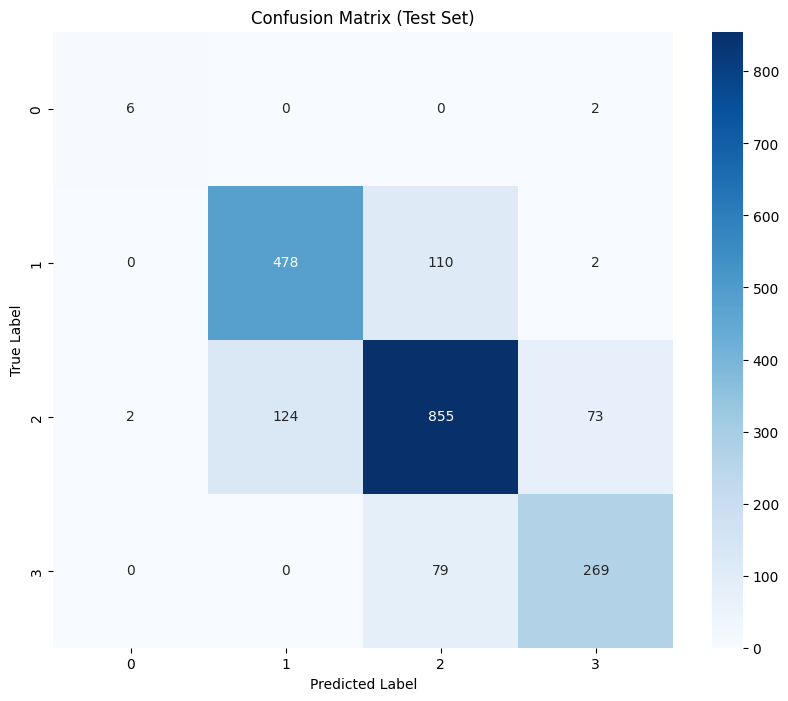

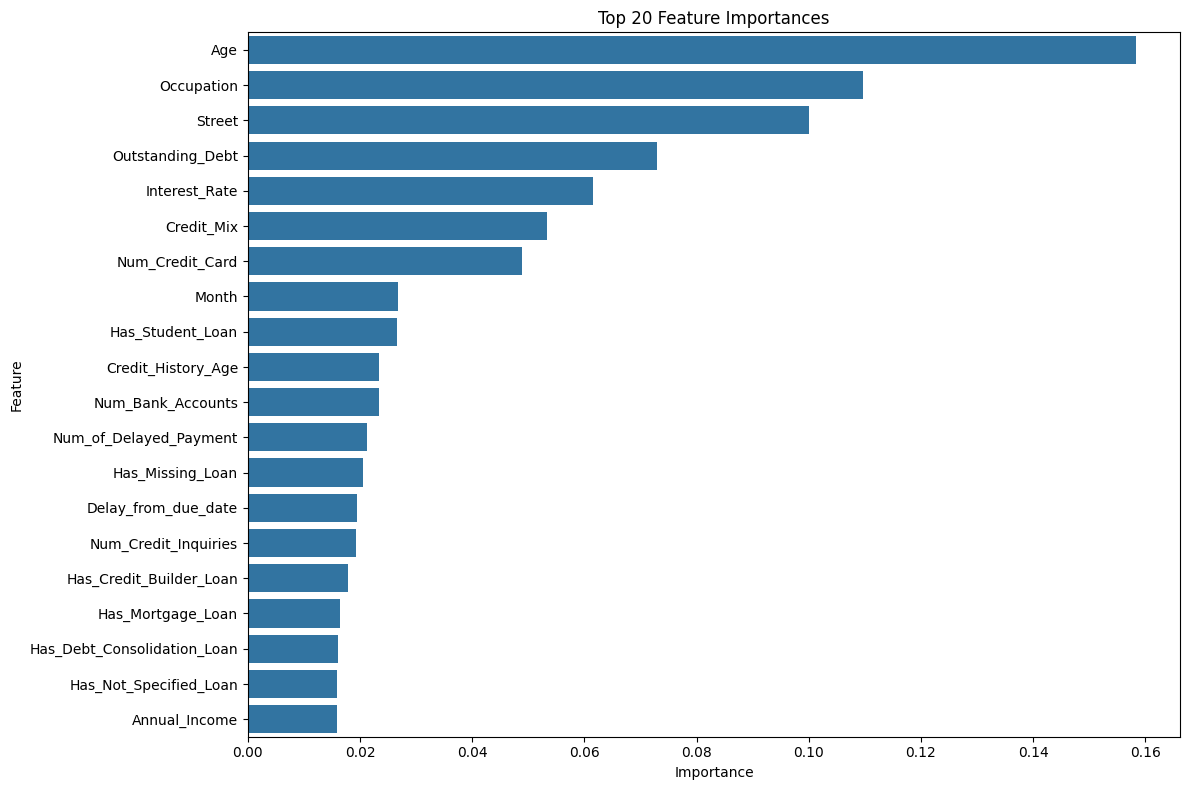

In [ ]:
import importlib
import src.models.credit_score_pipeline as pipeline_module
importlib.reload(pipeline_module)
from src.models.credit_score_pipeline import CreditScorePipeline

# Relative path from notebooks directory to config file
config_path = "../config.yaml"


"""Run the credit score classification pipeline."""


# Separate features and target
X = df.drop("Credit_Score", axis=1)
y = df["Credit_Score"]

# Initialize pipeline
pipeline = CreditScorePipeline(config_path=config_path, random_state=42)

# Run full pipeline
results = pipeline.run_full_pipeline(
    X, y, 
    test_size=0.2,
    val_size=0.2,
    n_iter=30,  # Number of hyperparameter combinations to try
    cv=5        # Number of cross-validation folds
)